## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

# Local imports from model.py, data.py
from model_v3 import CovidModel, Compartments, LogPoissonProb, get_logging_callbacks
from data_v3 import read_data, create_warmup
from plots_v3 import make_all_plots

## Controllable Parameters

### Data details

In [2]:
warmup_start = '20210401'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = './data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

log_dir = './logs/test_run_1'

### Model Settings

In [3]:
# How long can a person take to progress?
transition_window = 20

# CovidEstim Hyper param
T_serial = 5.8

### Model prior parameters

In [4]:
# Parameters for the Beta distribution prior over rho, the probablility that
# someone progresses to the next state. Here we use a uniform distribution
# for all compartments, but we could specify a different prior for each M, X, G

# Copied from covid estim
# covidestim infected -> symptoms
alpha_bar_M = 5.5
beta_bar_M = 3.53
# covidestim symptoms -> severe
alpha_bar_X = 1.89
beta_bar_X = 20
# covid estim severe -> death
alpha_bar_G = 28.2
beta_bar_G = 162.3

# Parameters for the positive truncated Normal distribution prior over lambda, the rate
# parameter of the Poisson distribution controlling pi,
# which determines how quickly someone who progresses does so +
# Parameters for the positive truncated Normal distribution prior over nu, the parameter used
# to scale the poisson distribution governed by pi, allowing for a more expressive
# range of possible transition days

# We choose these values to match the gamma priors in covid estim
# Covidestim infected -> symptoms = Gamma(3.41, 0.61)
lambda_bar_M = 4.7
sigma_bar_M = 1.00
nu_bar_M = 1.70
tau_bar_M = 0.10

# Covidestim Symptoms -> severe = Gamma(1.72, 0.22)
lambda_bar_X = 4
sigma_bar_X = 0.5
nu_bar_X = 18
tau_bar_X = 8.1

# Covidestim severe -> death = Gamma(2.10, 0.23)
lambda_bar_G = 3.3
sigma_bar_G = 1
nu_bar_G = 9
tau_bar_G = 0.2


# Learning rate
learning_rate = 1e-1

## Read data

In [5]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [6]:
# Optional, replace covidestim warmup data with fixed constants
#df.loc[:,'extreme'] = 7*df.loc[:,'general_ward']
#df.loc[:,'mild'] = 10*df.loc[:,'extreme']
#df.loc[:,'asymp'] = 1.5*df.loc[:,'mild']

## Create warmup using incorrect efficacy assumption

In [7]:
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end)

In [8]:
warmup_asymp

{'everyone': array([2880.28853607, 2843.6712517 , 2808.09964671, 2773.54471301,
        2740.04183883, 2707.68701071, 2676.63167199, 2647.05767171,
        2619.16077345, 2593.15042468, 2569.25021575, 2547.69671657,
        2528.70304474, 2512.42860207, 2498.98184307, 2488.42348604,
        2480.76831893, 2475.97009699, 2473.90355126, 2474.36297005,
        2477.06048683, 2481.62355184, 2487.60345675, 2494.48897379,
        2501.70467154, 2508.60880071, 2514.49283934, 2518.60923786,
        2520.22371777, 2518.626799  ])}

## Create training Rt and outcome

In [9]:
training_rt = df.loc[train_start:train_end,'Rt'].values
training_general_ward = df.loc[train_start:train_end,'general_ward'].values

# Start the model from the training period so we are continuous
testing_rt = df.loc[train_start:test_end,'Rt'].values
testing_general_ward = df.loc[train_start:test_end,'general_ward'].values

## Build Model

In [10]:
model = CovidModel(transition_window, T_serial,
                     alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                 lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                 nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_X, tau_bar_X)

## Fit model

In [11]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
)

loss = LogPoissonProb()

model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
callbacks = get_logging_callbacks(log_dir)

In [15]:
# Awkwardly stuff everything into an array

model.fit(x=(np.asarray([training_rt]),
       np.asarray([warmup_asymp['everyone']]), 
       np.asarray([warmup_mild['everyone']]), 
       np.asarray([warmup_extreme['everyone']])), 
             y=np.asarray([training_general_ward]),
         epochs=500, batch_size=0, callbacks=callbacks)

Epoch 1/500
1/1 [==============================] - 1s 910ms/step - loss: 2544.8474
Epoch 2/500
1/1 [==============================] - 2s 2s/step - loss: 2538.4829
Epoch 3/500
1/1 [==============================] - 1s 729ms/step - loss: 2532.4407
Epoch 4/500
1/1 [==============================] - 1s 671ms/step - loss: 2526.4556
Epoch 5/500
1/1 [==============================] - 1s 783ms/step - loss: 2520.0251
Epoch 6/500
1/1 [==============================] - 1s 780ms/step - loss: 2512.7830
Epoch 7/500
1/1 [==============================] - 1s 865ms/step - loss: 2504.6038
Epoch 8/500
1/1 [==============================] - 1s 810ms/step - loss: 2495.4399
Epoch 9/500
1/1 [==============================] - 1s 715ms/step - loss: 2485.2070
Epoch 10/500
1/1 [==============================] - 1s 850ms/step - loss: 2473.7478
Epoch 11/500
1/1 [==============================] - 1s 805ms/step - loss: 2460.8210
Epoch 12/500
1/1 [==============================] - 1s 841ms/step - loss: 2446.0950
Epoc

## Get predictions for train and test

In [16]:
train_preds = model((training_rt,
       warmup_asymp['everyone'], 
       warmup_mild['everyone'], 
       warmup_extreme['everyone']))

test_preds = model((testing_rt,
       warmup_asymp['everyone'], 
       warmup_mild['everyone'],
       warmup_extreme['everyone']))
    
test_loss = loss(tf.convert_to_tensor(testing_general_ward, dtype=tf.float32), test_preds)

## Call model with special flag to get values of all internal compartments

In [17]:
forecasted_fluxes = model((testing_rt,
       warmup_asymp['everyone'], 
       warmup_mild['everyone'], 
       warmup_extreme['everyone']), return_all=True)

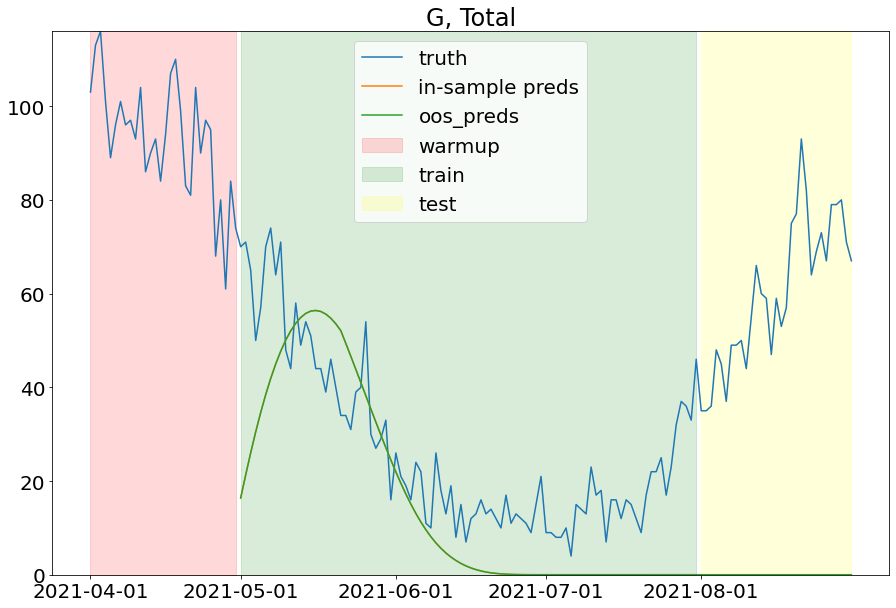

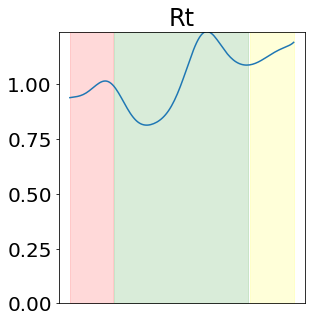

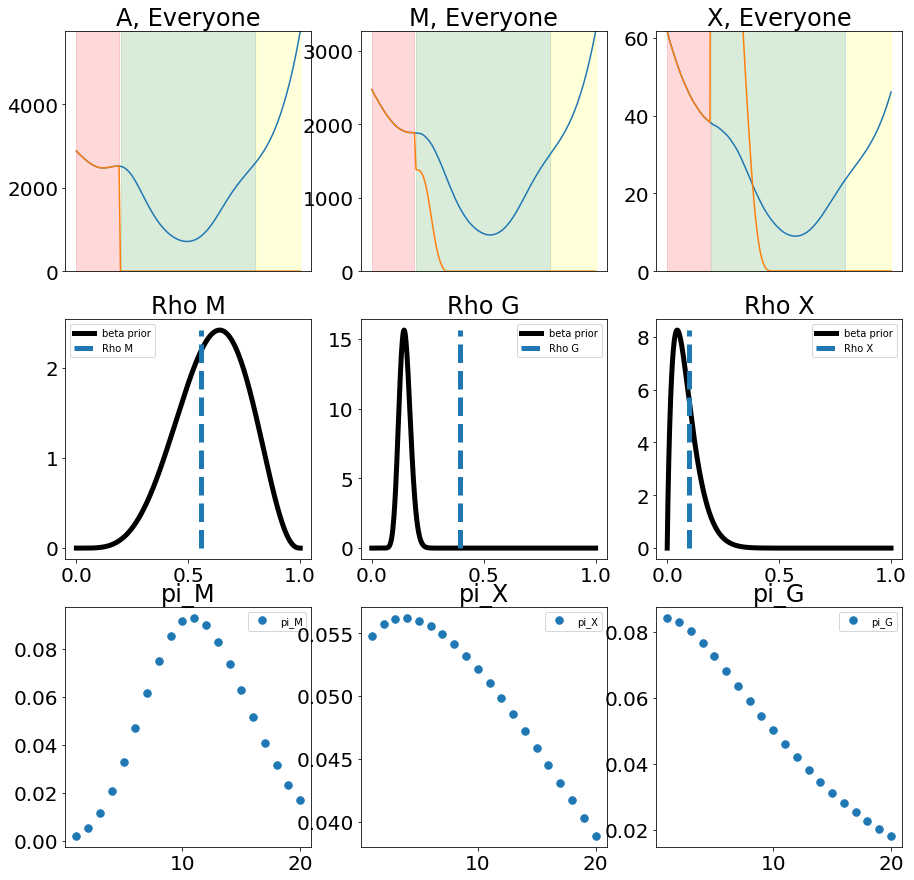

In [20]:
make_all_plots(df, model,
               alpha_bar_M, beta_bar_M,
               alpha_bar_X, beta_bar_X,
               alpha_bar_G, beta_bar_G,
                   warmup_start, warmup_end,
                   train_start, train_end,
                   test_start, test_end,
                   train_preds, test_preds,
                   forecasted_fluxes, save_path='./figs/v3.pdf')